In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from resnet18 import ResNet18

Hyperparameters

In [3]:
batch_size = 256
learning_rate = 0.01
norm_mean = (0.5, 0.5, 0.5) # to normalize each channel
norm_std = (0.5, 0.5, 0.5)  # to normalize each channel

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Utility function

In [4]:
def img_show(img:torch.Tensor):
    # unnormalize image tensor
    mean = torch.tensor(norm_mean).view(3,1,1)
    std = torch.tensor(norm_std).view(3,1,1)
    img = img * std + mean

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Setting up the data

In [5]:
# Transformations
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(32),                   # crop img to 32x32
    torchvision.transforms.RandomHorizontalFlip(),                  # flip horizontally
    torchvision.transforms.ToTensor(),                              # convert to tensor
    torchvision.transforms.Normalize(mean=norm_mean, std=norm_std)  # normalize
])

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=norm_mean, std=norm_std)
])

# Download CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform_test, download=True)

load_dataset = torchvision.datasets.DatasetFolder

# Split train dataset into train and validation
train_set, val_set = torch.utils.data.random_split(train_dataset, [0.90, 0.10])

# Data loaders
train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


look at the data

Input Tensor: torch.Size([3, 32, 32])
Label: 2


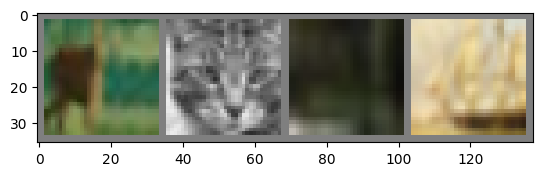

deer  cat   truck ship 


In [5]:
imgs, labels = train_set[0]

print(f"Input Tensor: {imgs.shape}")
print(f"Label: {labels}")

data_iter = iter(train_loader)
imgs, labels = next(data_iter)

img_show(torchvision.utils.make_grid(imgs[:4]))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Trainer for the model

We'll use Learning Rate Scheduler to decrease the learning rate by `gamma` every `step_size` epochs.

<div style="display:flex; align-items:start; font-size:1.2rem"> 
    
$$\text{lr}_{\text{updated}} = \text{lr}_{\text{previous}} \times \gamma^{\left\lfloor\frac{\text{epoch}}{\text{step\_size}}\right\rfloor}$$
</div>


In [6]:
class Trainer:
    def __init__(self, model:nn.Module, epochs:int, lr:float=0.01) -> None:
        self.model = model
        self.epochs = epochs
        
        self.model.to(device)

        self.criterion = nn.CrossEntropyLoss()
        self.optim = torch.optim.Adam(model.parameters(), lr=lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optim, step_size=10, gamma=0.1)

        # model metrics
        self.train_losses, self.val_losses = [], []
        self.train_accs, self.val_accs = [], []
        

    def train(self, train_loader:DataLoader, val_loader:DataLoader) -> None:
        for epoch in range(self.epochs):
            t_batch_loss, v_batch_loss = [], []
            t_batch_acc, v_batch_acc = [], []
            
            self.model.train()
            pbar = tqdm(train_loader, total=len(train_loader))
            pbar.set_description(f"Epoch {epoch+1:2d}/{self.epochs:2d}")
            pbar.bar_format = "{l_bar}{bar:20}| {n_fmt}/{total_fmt}{postfix}"
            for (x, y) in pbar:
                x, y = x.to(device), y.to(device)
                
                self.optim.zero_grad()
                y_pred = self.model(x)
                loss = self.criterion(y_pred, y)

                loss.backward()
                self.optim.step()

                t_batch_loss.append(loss.item())
                t_batch_acc.append(self.__accuracy(y_pred, y))

                pbar.set_postfix({'loss': loss.item(), 'acc': self.__accuracy(y_pred, y).item()})

            self.train_losses.append(sum(t_batch_loss)/len(t_batch_loss))   # append average loss
            self.train_accs.append(sum(t_batch_acc)/len(t_batch_acc))       # append average accuracy

            self.model.eval()
            with torch.no_grad():
                for (x_v, y_v) in val_loader:
                    x_v, y_v = x_v.to(device), y_v.to(device)
                    y_pred = self.model(x_v)
                    loss = self.criterion(y_pred, y_v)

                    v_batch_loss.append(loss.item())
                    v_batch_acc.append(self.__accuracy(y_pred, y_v))
                
                
            self.val_losses.append(sum(v_batch_loss)/len(v_batch_loss))
            self.val_accs.append(sum(v_batch_acc)/len(v_batch_acc))

            tqdm.write(f"LOSS: train={self.train_losses[-1]:.4f}, val={self.val_losses[-1]:.4f}, ACC: train={self.train_accs[-1]:.4f}, val={self.val_accs[-1]:.4f}\n")

    def test(self, test_loader:DataLoader) -> float:
        self.model.eval()
        with torch.no_grad():
            t_batch_acc = []
            for (x_t, y_t) in test_loader:
                x_t, y_t = x_t.to(device), y_t.to(device)
                y_pred = self.model(x_t)
                t_batch_acc.append(self.__accuracy(y_pred, y_t))

        return sum(t_batch_acc)/len(t_batch_acc) # return average accuracy

    def __accuracy(self, preds: torch.Tensor, labels: torch.Tensor) -> float:
        preds = torch.argmax(preds, dim=1)
        return torch.sum(preds == labels)/len(preds)

Let's see if the PyTorch's inbuilt ResNet18 model and Our ResNet18 model performs the same on CIFAR10 dataset with pretrained weights.

In [7]:
pytorch_r18 = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
pytorch_r18.fc = nn.Linear(in_features=512, out_features=10) # changing head for our use case

our_r18 = ResNet18.from_pretrained(n_classes=10) # our implementation already has head for CIFAR-10

Loading weights for ResNet18 model


Training PyTorch's ResNet18 model

In [10]:
pytorch_r18_trainer = Trainer(pytorch_r18, epochs=30, lr=learning_rate)
pytorch_r18_trainer.train(train_loader, val_loader)

Training Our ResNet18 model

In [8]:
our_r18_trainer = Trainer(our_r18, epochs=30, lr=learning_rate)
our_r18_trainer.train(train_loader, val_loader)

Evaluating both models

In [13]:
their_acc = pytorch_r18_trainer.test(test_loader)
out_acc = our_r18_trainer.test(test_loader)

print(f"PyTorch ResNet18 Accuracy: {their_acc:.4f}")
print(f"Our ResNet18 Accuracy: {out_acc:.4f}")

PyTorch ResNet18 Accuracy: 0.0704
Our ResNet18 Accuracy: 0.0705


**Note**: I did not train the models at all, it'll take a lot of time on my cpu-only machine. But after 30 epochs of training, both models should give ~76% accuracy on the validation set.